# 0. 데이터 준비

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import datetime
from scipy.stats import skew
from sklearn.preprocessing import MinMaxScaler
from lightgbm import LGBMRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.model_selection import StratifiedKFold, train_test_split,KFold
from sklearn.metrics import roc_auc_score,average_precision_score, confusion_matrix,classification_report,precision_recall_curve,accuracy_score, recall_score, f1_score,precision_score
import time
import seaborn as sns
import joblib
import shap

/Users/pg/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
train = pd.read_csv('data/lending_club_2020_train.csv')
test = pd.read_csv('data/lending_club_2020_test.csv')

/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_4093/4166847255.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('data/lending_club_2020_train.csv')


# 1. 데이터 전처리 함수 정의 

In [4]:
# addr_state 유지
def drop(df):
    # 삭제할 컬럼 리스트
    drop_cols = [
        'issue_d', 'last_pymnt_d', 'term', 'risk_free',
        'installment', 'recoveries', 'total_pymnt', 
        'last_pymnt_amnt','total_rec_prncp', 'funded_amnt',
        'installment', 'int_rate', 'total_pymnt_inv', 'funded_amnt_inv',
        'grade', 'sub_grade', 'pymnt_plan', 'url', 'title', 'zip_code',
        'delinq_2yrs', 'mths_since_last_record', 'initial_list_status', 'out_prncp',
        'out_prncp_inv', 'total_pymnt', 
        'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
        'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
        'last_fico_range_high', 'last_fico_range_low', 'mths_since_last_major_derog',
        'policy_code', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
        'open_acc_6m', 'open_il_12m', 'open_il_24m', 'total_bal_il', 'open_rv_12m',
        'open_rv_24m', 'max_bal_bc', 'all_util', 'avg_cur_bal',
        'chargeoff_within_12_mths', 'delinq_amnt', 'mths_since_recent_bc_dlq',
        'mths_since_recent_revol_delinq', 'num_rev_accts', 'num_tl_120dpd_2m',
        'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
        'sec_app_chargeoff_within_12_mths', 'hardship_flag', 'hardship_type',
        'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount',
        'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date',
        'hardship_length', 'hardship_dpd', 'hardship_loan_status',
        'orig_projected_additional_accrued_interest',
        'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
        'debt_settlement_flag', 'emp_title', 'earliest_cr_line', 'sec_app_earliest_cr_line', 'issue_d', 'purpose',
        'sec_app_revol_util', 'sec_app_num_rev_accts',
        'sec_app_open_acc', 'il_util', 'inq_fi',
        'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_collections_12_mths_ex_med',
        'sec_app_open_act_il'
    ]
        # 결측치 행 삭제 대상 컬럼 리스트
    dropna_cols = [
        'tax_liens',
        'collections_12_mths_ex_med',
        'num_accts_ever_120_pd',
        'mo_sin_old_il_acct',
        'mo_sin_rcnt_tl',
        'mo_sin_old_rev_tl_op',
        'num_il_tl',
        'pct_tl_nvr_dlq',
        'tot_hi_cred_lim',
        'last_pymnt_d'
    ]
    # 해당 변수들 중 결측치가 있는 행 삭제
    df.dropna(subset=dropna_cols, inplace=True)

    df = df.drop(columns=drop_cols)

    return df

In [5]:
def fill_missing_values(df):
    """
    결측치 처리 전용 함수
    """
    fill_minus1_cols = [
        'sec_app_fico_range_low','sec_app_fico_range_high'
    ]

    fill_zero_cols = [
        'inq_last_12m'
    ]

    fill_999_cols = [
        'dti', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'total_cu_tl',
        'open_act_il', 'mths_since_recent_inq'
    ]

    df[fill_minus1_cols] = df[fill_minus1_cols].fillna(-1)
    df[fill_zero_cols] = df[fill_zero_cols].fillna(0)
    df[fill_999_cols] = df[fill_999_cols].fillna(999)

    return df

In [6]:
def preprocess_data(df):

    """
    전처리 전체 파이프라인
    - df: 처리할 데이터프레임
    return: (전처리된 df)
    """

    # 2. 범주형 통합 및 원핫 or 순서형 인코딩

    df['application_type'] = df['application_type'].map({'Individual': 0, 'Joint App': 1})
    
    df = pd.get_dummies(df, columns=['term_norm'], prefix='term')

    # 컬럼 평균
    df["sec_app_fico_mean"] = df[["sec_app_fico_range_low", "sec_app_fico_range_high"]].mean(axis=1)
    df["total_limit_mean"] = df[["total_rev_hi_lim", "total_rev_hi_lim"]].mean(axis=1)


    # pub_rec, tax_liens: 이진 변수화
    df["pub_rec_flag"] = df["pub_rec"].apply(lambda x: 1 if x > 0 else 0)
    df["tax_liens_flag"] = df["tax_liens"].apply(lambda x: 1 if x > 0 else 0)


    # emp_length 결측치 unknown으로 바꾸고 원핫
    df['emp_length'] = df['emp_length'].fillna('Unknown')
    
    #!! addr_state 결측치 unknown으로 바꾸고 원핫
    df['addr_state'] = df['addr_state'].fillna('Unknown')


    # joint가 있으면 joint로 대체
    df['dti'] = df['dti_joint'].fillna(df['dti'])
    df['annual_inc'] = df['annual_inc_joint'].fillna(df['annual_inc'])
    df['verification_status'] = df['verification_status_joint'].fillna(df['verification_status'])
    df['revol_bal'] = df['revol_bal_joint'].fillna(df['revol_bal'])

    # 가중평균 (2:1)
    df['weighted_inq'] = (df['inq_last_6mths']*2 + df['inq_last_12m']*1) / 3



    # 원핫 인코딩 적용
    df = pd.get_dummies(df, columns=['emp_length'], prefix='emp_length')
    df = pd.get_dummies(df, columns=['home_ownership'], prefix='home')
    df = pd.get_dummies(df, columns=['verification_status'], prefix='verification_status')
    #!추가 addr_state
    df = pd.get_dummies(df, columns=['addr_state'], prefix='addr_state')


    df['revol_util'] = df['revol_util'].str.replace('%', '', regex=False).astype(float)
    # 매핑 딕셔너리 정의

    # 평균으로 대체
    df['percent_bc_gt_75'] = df['percent_bc_gt_75'].fillna(df['percent_bc_gt_75'].mean())
    df['bc_open_to_buy'] = df['bc_open_to_buy'].fillna(df['bc_open_to_buy'].mean())
    df['mths_since_recent_bc'] = df['mths_since_recent_bc'].fillna(df['mths_since_recent_bc'].mean())

    # 공동 대출 여부에 따라 결측치를 해당 그룹의 중앙값으로 대체
    cols_to_impute = ['revol_util', 'bc_util']

    for col in cols_to_impute:
        imputed_values = df.groupby('application_type')[col].transform('median')
        df[col] = df[col].fillna(imputed_values)


    # 원래 열 제거
    df.drop(columns=['dti_joint'], inplace=True)
    df.drop(columns=['annual_inc_joint'], inplace=True)
    df.drop(columns=['verification_status_joint'], inplace=True)
    df.drop(columns=['revol_bal_joint'], inplace=True)

    return df

In [7]:
def log_transform(df):
    # 숫자형 컬럼 추출
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

    # 로그 변환 제외 컬럼 (id, target, 주소 등)
    exclude_cols = ['id']
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # 2개 이하 unique 값 제외
    sequence_cols = [n for n in numeric_cols if df[n].nunique() > 2]

    # 각 컬럼의 왜도 계산
    skewness = df[sequence_cols].apply(lambda x: skew(x.dropna()))
    high_skew_cols = skewness[skewness.abs() > 1].index.tolist()

    # 로그 변환
    for col in high_skew_cols:
        df[col] = np.log1p(df[col].clip(lower=1e-6))

    return df

In [8]:
def split_data(df, target_col='excess_return'):
    """
    ✅ 회귀 모델 학습용 데이터 분리 함수
    - target: excess_return (또는 irr)
    - NaN 제거
    - 불필요한 컬럼 드롭
    """
    # 1️⃣ 타깃 결측 제거
    df = df[df[target_col].notna()].copy()

    # 2️⃣ X / y 분리
    y = df[target_col]
    drop_cols = [target_col]


    X = df.drop(columns=drop_cols)

    return X, y

## 1-1. 데이터셋 기반으로 IRR 계산

In [9]:
pip install numpy_financial


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install pandas_datareader

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import numpy_financial as npf
from datetime import datetime
from dateutil.relativedelta import relativedelta

def normalize_term(x):
    s = str(x)
    if "36" in s: return 36
    if "60" in s: return 60
    return pd.NA

def get_excess_return(df):
    
    df["issue_d"] = pd.to_datetime(df["issue_d"], errors="coerce")
    df["term_norm"] = df["term"].apply(normalize_term)
    
    # 1) FRED 금리 (3Y/5Y) 내려받기
    start = df["issue_d"].min() - pd.Timedelta(days=7)
    end   = df["issue_d"].max() + pd.Timedelta(days=7)
    
    rf = web.DataReader(["DGS3", "DGS5"], "fred", start, end)  # index=DATE
    rf = rf.rename(columns={"DGS3": "rf_3y", "DGS5": "rf_5y"})
    
    # 2) df 날짜 기준으로 reindex, 휴일은 직전 영업일 값으로
    rf_matched = rf.reindex(df["issue_d"], method="ffill")
    
    # 3) FRED 원천에 NaN이 있으면 최근 영업일 값으로 다시 ffill/bfill
    rf_matched = rf_matched.ffill().bfill()
    
    # 4) 행별 만기에 맞춰 risk_free 선택 후 소수 변환
    df["risk_free"] = np.where(
        df["term_norm"].eq(36), rf_matched["rf_3y"] / 100.0,
        np.where(df["term_norm"].eq(60), rf_matched["rf_5y"] / 100.0, np.nan)
    )
    
    # (선택) 간단 점검
    # 유효 만기 행에서 누락 몇 개?
    mask = df["issue_d"].notna() & df["term_norm"].isin([36,60])
    print("결측 개수:", df.loc[mask, "risk_free"].isna().sum())
    df['risk_free'].dropna(inplace=True)
    df['risk_free'] = df['risk_free']*(1/12)
    print(df[["issue_d","term_norm","risk_free"]].head())

    # 부도 여부: Fully Paid → 0, Charged Off,Default → 1
    status_map = {
        'Fully Paid': 0,
        'Charged Off': 1,
        'Default' : 1
    }
    df['loan_status'] = df['loan_status'].map(status_map)
    
    # 6.타깃값 0/1만 남기기
    df = df[df['loan_status'].isin([0, 1])].copy()

    

    # 날짜 형식 변환
    df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')  # 예: Jan-2020
    df['last_pymnt_d'] = pd.to_datetime(df['last_pymnt_d'], format='%b-%Y')
    
    # 개월 수 계산
    df['n_months'] = df.apply(lambda row: max(1, (row['last_pymnt_d'].year - row['issue_d'].year) * 12 +
                                               (row['last_pymnt_d'].month - row['issue_d'].month)), axis=1)

    
        
    df['irr'] = df.apply(calc_irr_by_threshold, axis=1)  # y로 사용
    # -----------------------------
    # 3) Risk-free 비교 및 파생
    # -----------------------------
    # risk_free는 이미 존재한다고 했으므로 그대로 사용하되, 단위 보정만
    
    df['excess_return'] = df['irr'] - df['risk_free']
    
    # -----------------------------
    # 4) 점검
    # -----------------------------
    print("IRR(연환산) 평균:", df['irr'].mean())
    print("IRR(연환산) 중앙값:", df['irr'].median())
    print("IRR < 0 비율:", (df['irr'] < 0).mean())
    print("IRR > risk_free 비율:", len(df[df['excess_return']>0]) / len(df))
    
    cols_show = ['id', 'loan_amnt', 'installment',
                 'loan_status',
                 'n_months', 'irr', 'excess_return']
    
    
    print(df[cols_show].head(10))
    return df.drop(columns=['irr', 'n_months'])

# 4. IRR 계산 함수 정의
def calc_irr_by_threshold(row):
    try:
        loan_amnt = row['loan_amnt']
        term = int(row['term_norm'])
        installment = row['installment']
        recoveries = row['recoveries']
        elapsed = row['n_months']
        total_pymnt = row['total_pymnt'] # 회계 기준일에 처리된 총액
        loan_status = row['loan_status']
        last_pymnt = row['last_pymnt_amnt'] # 납부된 당일 금액
        cashflow = []
        if loan_status==0: # 부도 안냄
            if elapsed < term: # 조기상환
                if elapsed <= 1: # 1달만에 갚으면 분모가 0이 되버림 (밑에 /(elapsed-1) 때문에)
                    cashflow = [-loan_amnt] + [total_pymnt]
                else:
                    actual_monthly_payment = (total_pymnt-last_pymnt) / (elapsed-1)
                    cashflow = [-loan_amnt] + [actual_monthly_payment] * (elapsed-1) + [last_pymnt]
            else: # 정상 상환
                cashflow = [-loan_amnt] + [installment] * term
        else: # 투자했는데 부도냄
            cashflow = [-loan_amnt] + [installment] * (elapsed-1) + [last_pymnt, recoveries]
        irr_value = npf.irr(cashflow)
        return float(irr_value) if np.isfinite(irr_value) else np.nan

    except Exception as e:
        print(f"Error at row {row.name}: {e}")
        return np.nan


## 1-2. 모델용 데이터 전처리 적용

In [12]:
# get excess_return
train = get_excess_return(train)
test = get_excess_return(test)


결측 개수: 0
     issue_d term_norm  risk_free
0 2017-12-01        36   0.001583
1 2018-09-01        60   0.002283
2 2016-07-01        60   0.000833
3 2017-12-01        36   0.001583
4 2019-04-01        36   0.001908
IRR(연환산) 평균: -0.014350315908610476
IRR(연환산) 중앙값: 0.009159538796039923
IRR < 0 비율: 0.1739505947197345
IRR > risk_free 비율: 0.8178991108769742
           id  loan_amnt  installment  loan_status  n_months       irr  \
0   124989905     6000.0       187.94          0.0        28  0.006467   
2    84253847    23200.0       680.82          1.0         5 -0.176543   
5   119708428    16000.0       494.55          1.0        22 -0.023120   
6   109906493     4500.0       146.10          0.0        22  0.009245   
7    60286250    20000.0       645.25          0.0        37  0.008325   
8   151871973    19000.0       482.17          1.0         1 -0.974623   
12   91934591    30000.0      1114.76          1.0        17 -0.030246   
13  144913775    16000.0       342.56          1.0     

In [13]:
#!추가
#파생변수 만들기 
# 모델학습 이후 Feature Impractance가 높게나오는 파생변수가있다면 공유해 주세요 
# 이미 train / test 나누어졌으니 train과 test모두에 적용해주세요.
train['credit_utilization_ratio'] = train['total_bal_ex_mort'] / (train['total_bc_limit'] + 1) #신용카드 한도 대비 실제 부채 사용률
train['loan_per_month'] = train['loan_amnt'] / (train['term_norm'] + 1)
train['loan_income_ratio'] = train['loan_amnt'] / (train['annual_inc'] + 1)
train['fico_mean'] = (train['fico_range_low'] + train['fico_range_high']) / 2
train['loan_to_credit_limit'] = train['loan_amnt'] / (train['tot_hi_cred_lim'] + 1)
train['mortgage_ratio'] = train['mort_acc'] / (train['total_acc'] + 1)
train['high_utilization_score'] = (train['percent_bc_gt_75'] * train['bc_util']) / 100

test['credit_utilization_ratio'] = test['total_bal_ex_mort'] / (test['total_bc_limit'] + 1) #신용카드 한도 대비 실제 부채 사용률
test['loan_per_month'] = test['loan_amnt'] / (test['term_norm'] + 1)
test['loan_income_ratio'] = test['loan_amnt'] / (test['annual_inc'] + 1)
test['fico_mean'] = (test['fico_range_low'] + test['fico_range_high']) / 2
test['loan_to_credit_limit'] = test['loan_amnt'] / (test['tot_hi_cred_lim'] + 1)
test['mortgage_ratio'] = test['mort_acc'] / (test['total_acc'] + 1)
test['high_utilization_score'] = (test['percent_bc_gt_75'] * test['bc_util']) / 100

test['addr_state_IA'] =0

train['loan_per_month'] = pd.to_numeric(train['loan_per_month'], errors='coerce')
test['loan_per_month'] = pd.to_numeric(test['loan_per_month'], errors='coerce')

In [14]:

# 1️⃣ Drop
train = drop(train)

# 2️⃣ 결측치 처리
train = fill_missing_values(train)


In [15]:
# 3️⃣ 데이터 전처리 (스케일링, 원핫인코딩 등)
train = preprocess_data(train)

# 1️⃣ Drop
test = drop(test)

# 2️⃣ 결측치 처리
test = fill_missing_values(test)

# 3️⃣ 데이터 전처리 (스케일링, 원핫인코딩 등)
test = preprocess_data(test)


/var/folders/10/60hqtvh14mx_q270xg8q82qc0000gn/T/ipykernel_4093/814866263.py:13: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  df = pd.get_dummies(df, columns=['term_norm'], prefix='term')


In [16]:
#도움안되는 녀석들 삭제
drop_columns = [
    'addr_state_ID', 'addr_state_KY', 'addr_state_ND', 'addr_state_TN', 'addr_state_NE',
    'addr_state_NH', 'addr_state_DE', 'addr_state_NV',
    'emp_length_1 year', 'emp_length_4 years', 'emp_length_6 years', 'emp_length_8 years',
    #'home_ANY', 'home_OTHER', 'home_NONE',
    'addr_state_KS', 'addr_state_AK', 'addr_state_HI'
]
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

In [17]:
train_X, train_y= split_data(train)
test_X, test_y= split_data(test)


In [18]:
train_X = log_transform(train_X)
test_X = log_transform(test_X)

In [19]:
# object 타입 컬럼만 추출
obj_cols = train_X.select_dtypes(include=['object']).columns
print("🔎 object 타입 컬럼 목록:", list(obj_cols))

# 각 object 컬럼별 값 분포 (상위 10개)
for col in obj_cols:
    print(f"\n📌 {col} 값 분포:")
    print(train_X[col].value_counts(dropna=False).head(10))

🔎 object 타입 컬럼 목록: ['id']

📌 id 값 분포:
124989905    1
29023753     1
3347504      1
95310064     1
71633186     1
138404655    1
24013391     1
3701989      1
94469180     1
35053638     1
Name: id, dtype: int64


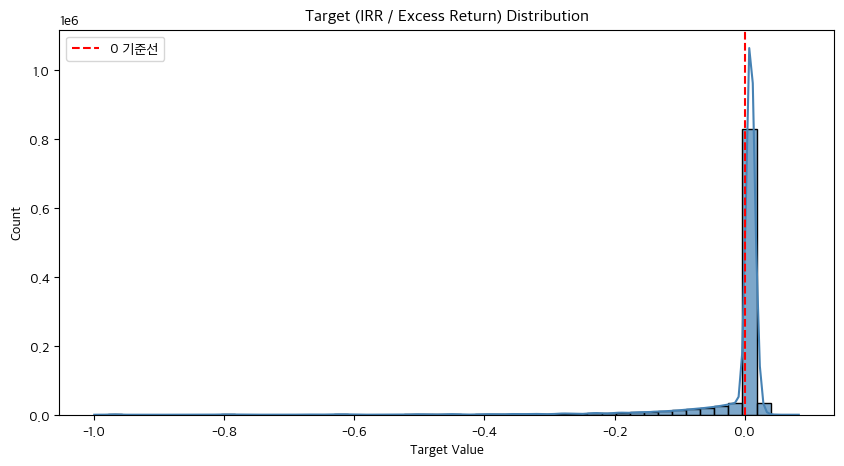

In [20]:
import seaborn as sns
plt.rc('font', family='Apple SD Gothic Neo')

# 마이너스 부호가 깨지는 것을 방지합니다.
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10,5))
sns.histplot(train_y, bins=50, kde=True, color="steelblue", alpha=0.7)
plt.axvline(0, color='red', linestyle='--', label='0 기준선')
plt.title("Target (IRR / Excess Return) Distribution")
plt.xlabel("Target Value")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2. 모델 학습 (최종모델인 LGBM의 최적화 과정)

In [21]:
pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [22]:
pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [23]:
train_X = train_X.drop(columns=['id'], errors='ignore')
test_X = test_X.drop(columns=['id'], errors='ignore')  

In [24]:

# ----------------------------
# ✅ LightGBM 회귀 모델 정의
# ----------------------------
lgbm_model = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1
)

# ----------------------------
# ✅ 탐색 공간 정의 (회귀도 동일)
# ----------------------------
search_spaces = {
    'n_estimators': Integer(200, 500),
    'max_depth': Integer(5, 25),
    'num_leaves': Integer(20, 1000),
    'min_child_samples': Integer(10, 50),
    'learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'subsample': Real(0.6, 0.9),
    'colsample_bytree': Real(0.6, 0.9),
    'min_split_gain': Real(0.0, 0.5),
    'reg_alpha': Real(0.0, 0.5),
    'reg_lambda': Real(0.1, 1.0)
}

# ----------------------------
# ✅ KFold로 교차검증 정의
# ----------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# ----------------------------
# ✅ Bayesian Optimization 실행
# ----------------------------
opt = BayesSearchCV(
    estimator=lgbm_model,
    search_spaces=search_spaces,
    n_iter=30,
    scoring='neg_mean_absolute_error',  # 회귀용 지표
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(train_X, train_y)

print("🔹 Best Parameters:", opt.best_params_)
print("🔹 Best CV MAE Score:", -opt.best_score_)  # 음수 제거

# ----------------------------
# ✅ 최적 모델로 최종 학습
# ----------------------------
best_model = opt.best_estimator_
best_model.fit(train_X, train_y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7889
[LightGBM] [Info] Number of data points in the train set: 833400, number of used features: 118
[LightGBM] [Info] Start training from score -0.014989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.105489 seconds.
You can set `forc

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.014732700212483641,
              max_depth=13, min_child_samples=30, n_estimators=200, n_jobs=-1,
              num_leaves=1000, objective='regression', random_state=42,
              reg_alpha=0.5, reg_lambda=0.8533329788771031,
              subsample=0.8007808758458215)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 예측
y_pred = best_model.predict(train_X)

# 기본 회귀 지표
mae = mean_absolute_error(train_y, y_pred)
rmse = np.sqrt(mean_squared_error(train_y, y_pred))
r2 = r2_score(train_y, y_pred)

print("📊 IRR 기반 회귀 평가 결과")
print(f"MAE  (평균 절대 오차): {mae:.6f}")
print(f"RMSE (제곱근 평균제곱 오차): {rmse:.6f}")
print(f"R²   (결정계수): {r2:.6f}")


📊 IRR 기반 회귀 평가 결과
MAE  (평균 절대 오차): 0.019991
RMSE (제곱근 평균제곱 오차): 0.061002
R²   (결정계수): 0.482694


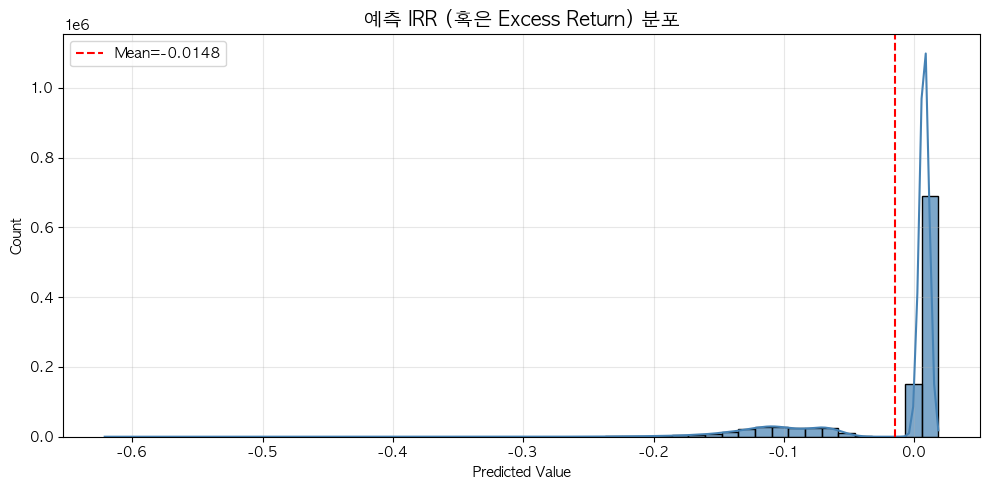

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

plt.figure(figsize=(10,5))
sns.histplot(y_pred, bins=50, kde=True, color="steelblue", alpha=0.7)
plt.axvline(np.mean(y_pred), color="red", linestyle="--", label=f"Mean={np.mean(y_pred):.4f}")
plt.title("예측 IRR (혹은 Excess Return) 분포", fontsize=14)
plt.xlabel("Predicted Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

예측 Sharpe (0 치환): 1.7168
실제 Sharpe (0 치환): 1.4528


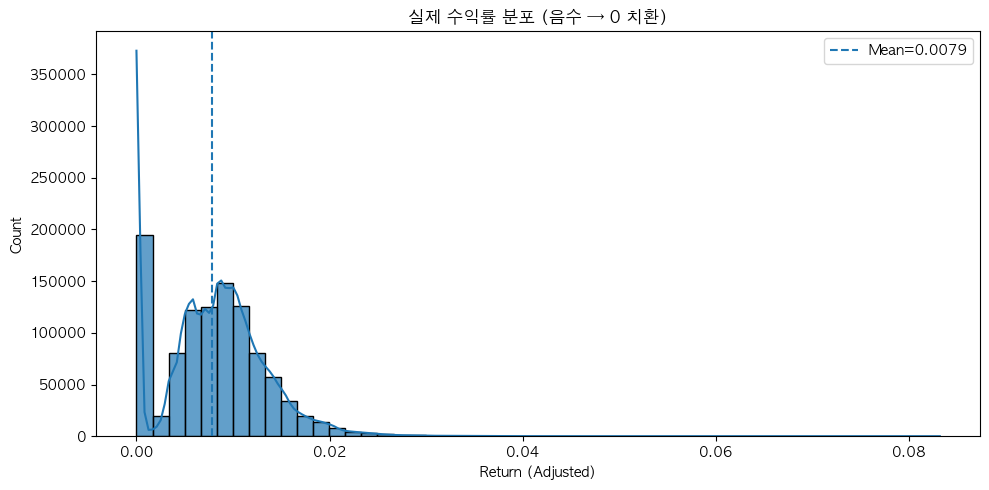

In [27]:
def _sharpe(arr):
    arr = np.asarray(arr, dtype=float)
    arr = np.where(arr < 0, 0, arr)  # 음수는 0으로 치환
    mu, sd = np.nanmean(arr), np.nanstd(arr)
    return np.nan if sd == 0 or np.isnan(sd) else mu / (sd + 1e-9)

# 예측값과 실제값을 모두 0 치환 버전으로 변환
y_pred_adj = np.where(y_pred < 0, 0, y_pred)
train_y_adj = np.where(train_y < 0, 0, train_y)

# Sharpe 계산
sharpe_pred = _sharpe(y_pred_adj)
sharpe_true = _sharpe(train_y_adj)

print(f"예측 Sharpe (0 치환): {sharpe_pred:.4f}")
print(f"실제 Sharpe (0 치환): {sharpe_true:.4f}")

# 시각화 (실제 수익률 분포, 0 치환 후)
plt.figure(figsize=(10,5))
sns.histplot(train_y_adj, bins=50, kde=True, alpha=0.7)
plt.axvline(np.mean(train_y_adj), linestyle='--', label=f"Mean={np.mean(train_y_adj):.4f}")
plt.title("실제 수익률 분포 (음수 → 0 치환)")
plt.xlabel("Return (Adjusted)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

📌 필터 기준: y_pred > 0
전체 샘플 수: 1,041,749  | 대출건 샘플 수: 837,556 (80.40%)
예측 분포 Sharpe (y_pred>0 subset): 1.7168
실제 분포 Sharpe (y_pred>0 subset의 train_y): 1.4064
전체 train_y Sharpe (모든 데이터): -0.1756


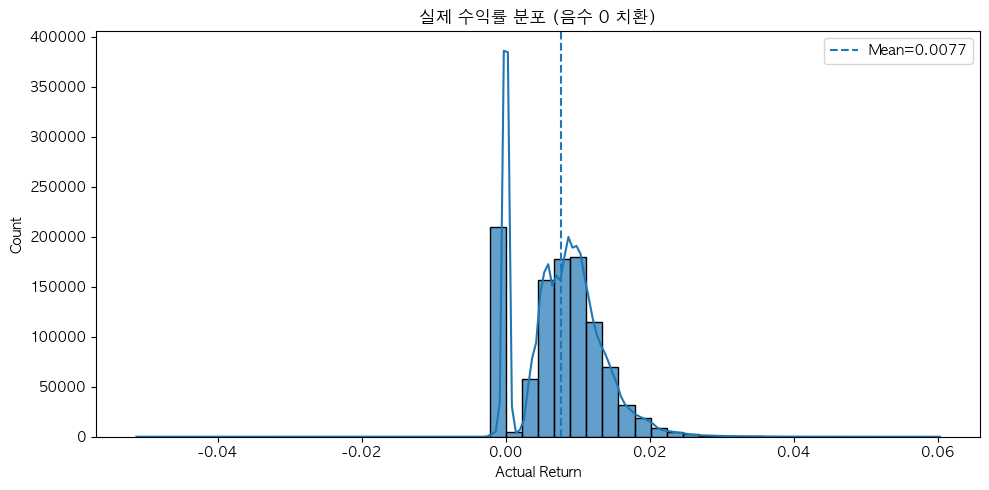

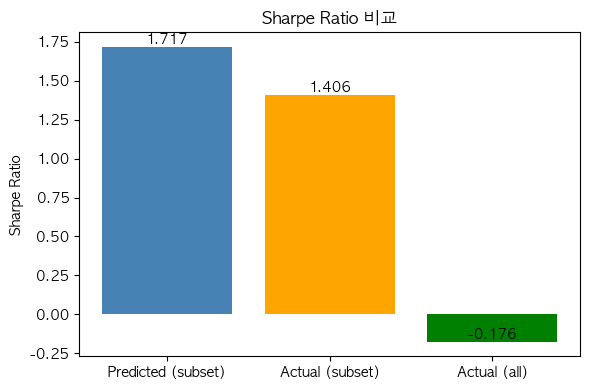

In [28]:
# 위 코드 블록 그대로 실행
sel_pred = pd.Series(np.where(y_pred < 0, 0, y_pred)).astype(float)
sel_true = pd.Series(np.where(y_pred < 0, 0, train_y)).astype(float)
n_pos_pred = (sel_pred > 0).sum()

# NA 제거
sel_pred = sel_pred.dropna()
sel_true = sel_true.dropna()

n_all  = len(y_pred)
n_keep = len(sel_pred)

def _sharpe(arr):
    arr = np.asarray(arr, dtype=float)
    mu, sd = np.nanmean(arr), np.nanstd(arr)
    return np.nan if sd == 0 or np.isnan(sd) else mu / (sd + 1e-9)

sharpe_pred = _sharpe(sel_pred)
sharpe_true = _sharpe(sel_true)
sharpe_true_all = _sharpe(train_y)

print("📌 필터 기준: y_pred > 0")
print(f"전체 샘플 수: {n_all:,}  | 대출건 샘플 수: {n_pos_pred:,} ({n_pos_pred/n_all:.2%})")
print(f"예측 분포 Sharpe (y_pred>0 subset): {sharpe_pred:.4f}")
print(f"실제 분포 Sharpe (y_pred>0 subset의 train_y): {sharpe_true:.4f}")
print(f"전체 train_y Sharpe (모든 데이터): {sharpe_true_all:.4f}")

# 2) 실제 수익률(=sel_true) 분포 시각화 + Sharpe 주석
plt.figure(figsize=(10,5))
sns.histplot(sel_true, bins=50, kde=True, alpha=0.7)
plt.axvline(sel_true.mean(), linestyle='--', label=f"Mean={sel_true.mean():.4f}")
plt.title("실제 수익률 분포 (음수 0 치환)")
plt.xlabel("Actual Return")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# 3) 예측 vs 실제 Sharpe 비교 바차트
plt.figure(figsize=(6,4))
vals = [sharpe_pred if np.isfinite(sharpe_pred) else 0.0,
        sharpe_true if np.isfinite(sharpe_true) else 0.0,
        sharpe_true_all if np.isfinite(sharpe_true_all) else 0.0
]
labels = ["Predicted (subset)", "Actual (subset)", "Actual (all)"]
bars = plt.bar(labels, vals, color=["steelblue", "orange", "green"])
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.3f}", ha='center', va='bottom')

plt.title("Sharpe Ratio 비교")
plt.ylabel("Sharpe Ratio")
plt.tight_layout()
plt.show()

In [29]:
# best_model을 파일로 저장
joblib.dump(best_model, "best_model_IRR_ty.pkl")
print("✅ 모델이 'best_model_IRR.pkl'로 저장되었습니다.")

✅ 모델이 'best_model_IRR.pkl'로 저장되었습니다.


## 2-1 Test 적용

In [30]:
best_model = joblib.load('best_model_IRR_ty.pkl')

In [31]:
#final_threshold = 0.46

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 1) 예측값 (회귀)
y_pred_test = best_model.predict(test_X)

# 2) 회귀 지표
mae_test = mean_absolute_error(test_y, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(test_y, y_pred_test))
r2_test = r2_score(test_y, y_pred_test)

print("📊 테스트셋 회귀 평가 결과")
print(f"MAE : {mae_test:.6f}")
print(f"RMSE: {rmse_test:.6f}")
print(f"R²  : {r2_test:.6f}")

# 3) 방향성 맞춤률 (Hit Ratio: 예측 부호 == 실제 부호)
hit_ratio = (np.sign(y_pred_test) == np.sign(test_y)).mean()
print(f"Hit Ratio (수익/손실 방향 맞춤률): {hit_ratio:.4f}")



📊 테스트셋 회귀 평가 결과
MAE : 0.021944
RMSE: 0.066389
R²  : 0.382910
Hit Ratio (수익/손실 방향 맞춤률): 0.9667


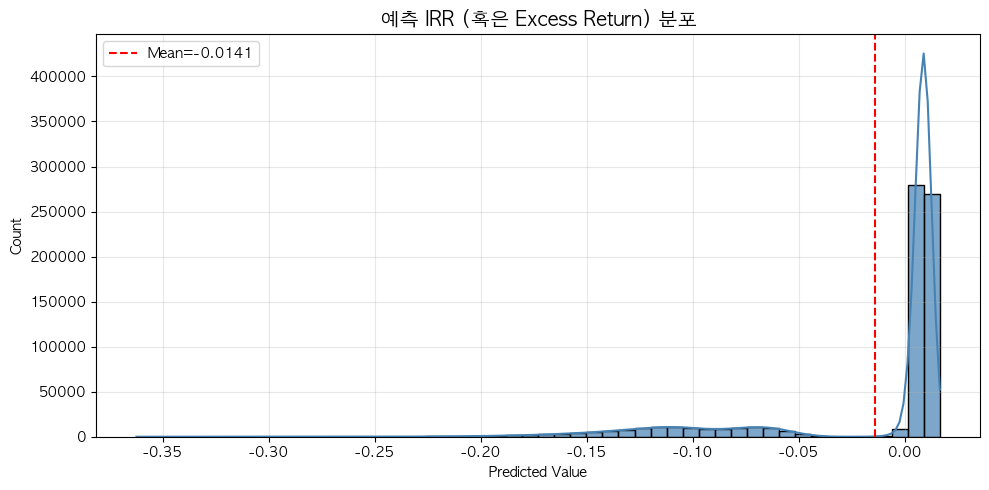

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(y_pred_test, bins=50, kde=True, color="steelblue", alpha=0.7)
plt.axvline(np.mean(y_pred_test), color="red", linestyle="--", label=f"Mean={np.mean(y_pred_test):.4f}")
plt.title("예측 IRR (혹은 Excess Return) 분포", fontsize=14)
plt.xlabel("Predicted Value")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

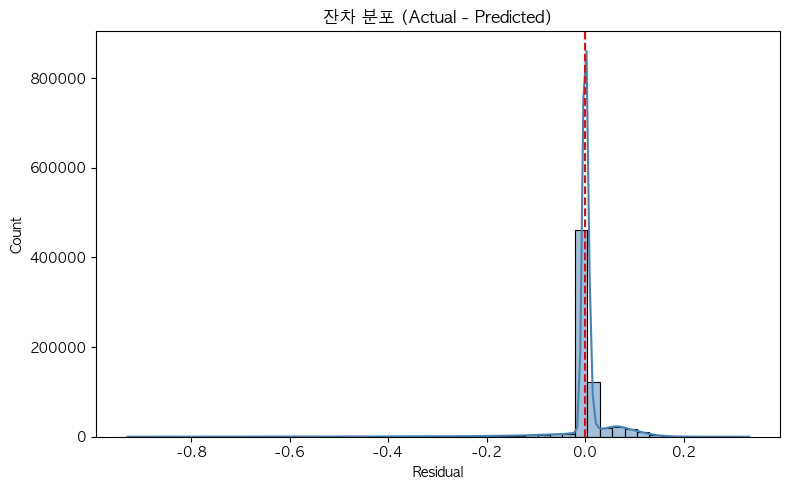

In [34]:
import seaborn as sns
import numpy as np

residuals = test_y - y_pred_test

plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")
plt.axvline(0, color='red', linestyle='--')
plt.title("잔차 분포 (Actual - Predicted)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

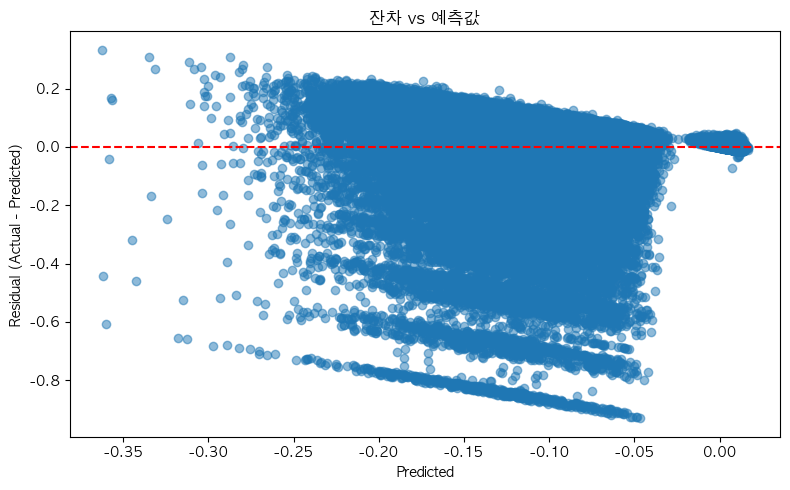

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("잔차 vs 예측값")
plt.tight_layout()
plt.show()

📌 필터 기준: y_pred_test > 0
전체 샘플 수: 694,809  | 0 이상의 샘플 수: 553,067 (79.60%)
예측 분포 Sharpe (y_pred_test>0 subset): 1.7102
실제 분포 Sharpe (y_pred_test>0 subset의 train_y): 1.3872
전체 test Sharpe (모든 데이터): -0.1760


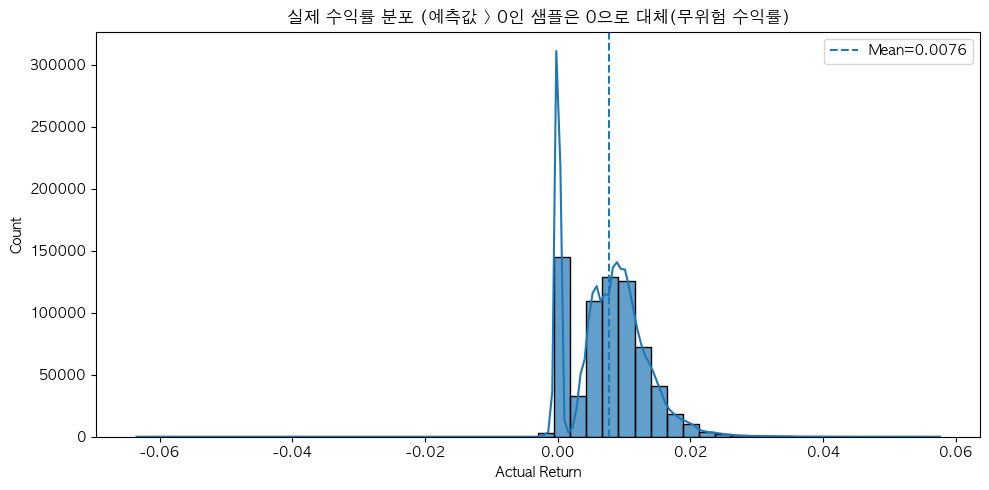

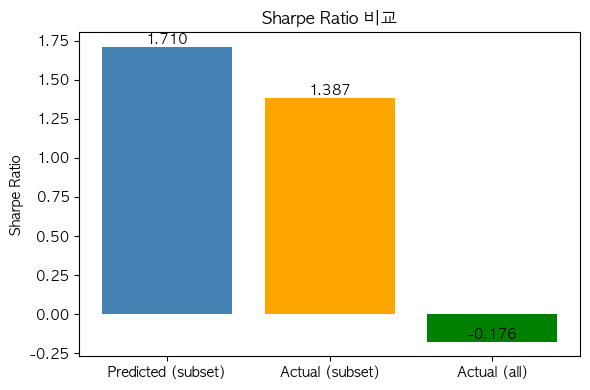

In [36]:
# 위 코드 블록 그대로 실행

# 1) 예측값 > 0 인 샘플만 선택
sel_pred = pd.Series(np.where(y_pred_test < 0, 0, y_pred_test)).astype(float)
sel_true = pd.Series(np.where(y_pred_test < 0, 0, test_y)).astype(float)
n_pos_pred = (sel_pred > 0).sum()


# NA 제거
sel_pred = sel_pred.dropna()
sel_true = sel_true.dropna()

n_all  = len(y_pred_test)
n_keep = len(sel_pred)

def _sharpe(arr):
    arr = np.asarray(arr, dtype=float)
    mu, sd = np.nanmean(arr), np.nanstd(arr)
    return np.nan if sd == 0 or np.isnan(sd) else mu / (sd + 1e-9)

sharpe_pred = _sharpe(sel_pred)
sharpe_true = _sharpe(sel_true)
sharpe_true_all = _sharpe(test_y)

print("📌 필터 기준: y_pred_test > 0")
print(f"전체 샘플 수: {n_all:,}  | 0 이상의 샘플 수: {n_pos_pred:,} ({n_pos_pred/n_all:.2%})")
print(f"예측 분포 Sharpe (y_pred_test>0 subset): {sharpe_pred:.4f}")
print(f"실제 분포 Sharpe (y_pred_test>0 subset의 train_y): {sharpe_true:.4f}")
print(f"전체 test Sharpe (모든 데이터): {sharpe_true_all:.4f}")

# 2) 실제 수익률(=sel_true) 분포 시각화 + Sharpe 주석
plt.figure(figsize=(10,5))
sns.histplot(sel_true, bins=50, kde=True, alpha=0.7)
plt.axvline(sel_true.mean(), linestyle='--', label=f"Mean={sel_true.mean():.4f}")
plt.title("실제 수익률 분포 (예측값 > 0인 샘플은 0으로 대체(무위험 수익률)")
plt.xlabel("Actual Return")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# 3) 예측 vs 실제 Sharpe 비교 바차트
plt.figure(figsize=(6,4))
vals = [sharpe_pred if np.isfinite(sharpe_pred) else 0.0,
        sharpe_true if np.isfinite(sharpe_true) else 0.0,
        sharpe_true_all if np.isfinite(sharpe_true_all) else 0.0
]
labels = ["Predicted (subset)", "Actual (subset)", "Actual (all)"]
bars = plt.bar(labels, vals, color=["steelblue", "orange", "green"])
for b, v in zip(bars, vals):
    plt.text(b.get_x() + b.get_width()/2, v, f"{v:.3f}", ha='center', va='bottom')

plt.title("Sharpe Ratio 비교")
plt.ylabel("Sharpe Ratio")
plt.tight_layout()
plt.show()

# 3. 모델 결과 해석

In [37]:
pd.set_option('display.max_rows', None)


# 피처 중요도 추출
feature_importance = best_model.feature_importances_

# DataFrame으로 변환
importance_df = pd.DataFrame({
    'Feature': test_X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# 상위 20개 피처 출력
print(importance_df)

                                 Feature  Importance
24                  mo_sin_old_rev_tl_op        9148
3                                    dti        8579
23                    mo_sin_old_il_acct        7992
51                     loan_income_ratio        7920
1                             annual_inc        6327
10                             revol_bal        6154
11                            revol_util        6054
53                  loan_to_credit_limit        6019
21                        bc_open_to_buy        5482
17                      total_rev_hi_lim        5437
0                              loan_amnt        5225
49              credit_utilization_ratio        4943
43                       tot_hi_cred_lim        4888
45                        total_bc_limit        4883
44                     total_bal_ex_mort        4832
22                               bc_util        4800
28                  mths_since_recent_bc        4792
46            total_il_high_credit_limit      

In [38]:

# 모델에서 학습한 feature 이름 가져오기
train_features = list(best_model.feature_name_)            # LightGBM
importances = np.asarray(best_model.feature_importances_, dtype=float)

imp_series = pd.Series(importances, index=train_features, name='Importance')
importance_df = imp_series.reset_index().rename(columns={'index': 'Feature'})


In [39]:

# 3) 합쳐야 할 prefix 매핑 정의
prefix_map = {
    'emp_length': 'emp_length_',
    'home_ownership': 'home_',
    'verification_status': 'verification_status_',
    'addr_state': 'addr_state_',
    # 필요하면 더 추가
}

# 4) Feature → 원본 컬럼 매핑
def map_to_orig(feature):
    for orig, pref in prefix_map.items():
        if feature.startswith(pref):
            return orig
    return feature  # 매핑 없으면 그대로 사용

importance_df['OrigFeature'] = importance_df['Feature'].apply(map_to_orig)

# 5) 그룹합 (합쳐진 중요도)
agg_importance = (importance_df
                  .groupby('OrigFeature', as_index=False)['Importance']
                  .sum()
                  .sort_values('Importance', ascending=False))

# 6) 출력
print("🔝 통합된 Feature Importance (Top 20)")
pd.set_option('display.max_rows', None)  # 최대 20개 행 출력
print(agg_importance)

🔝 통합된 Feature Importance (Top 20)
                   OrigFeature  Importance
23        mo_sin_old_rev_tl_op      9148.0
8                          dti      8579.0
22          mo_sin_old_il_acct      7992.0
18           loan_income_ratio      7920.0
2                   annual_inc      6327.0
48                   revol_bal      6154.0
49                  revol_util      6054.0
21        loan_to_credit_limit      6019.0
4               bc_open_to_buy      5482.0
64            total_rev_hi_lim      5437.0
17                   loan_amnt      5225.0
7     credit_utilization_ratio      4943.0
57             tot_hi_cred_lim      4888.0
60              total_bc_limit      4883.0
59           total_bal_ex_mort      4832.0
5                      bc_util      4800.0
30        mths_since_recent_bc      4792.0
62  total_il_high_credit_limit      4232.0
12              fico_range_low      4218.0
19              loan_per_month      4215.0
43              pct_tl_nvr_dlq      4115.0
13      high_utiliza

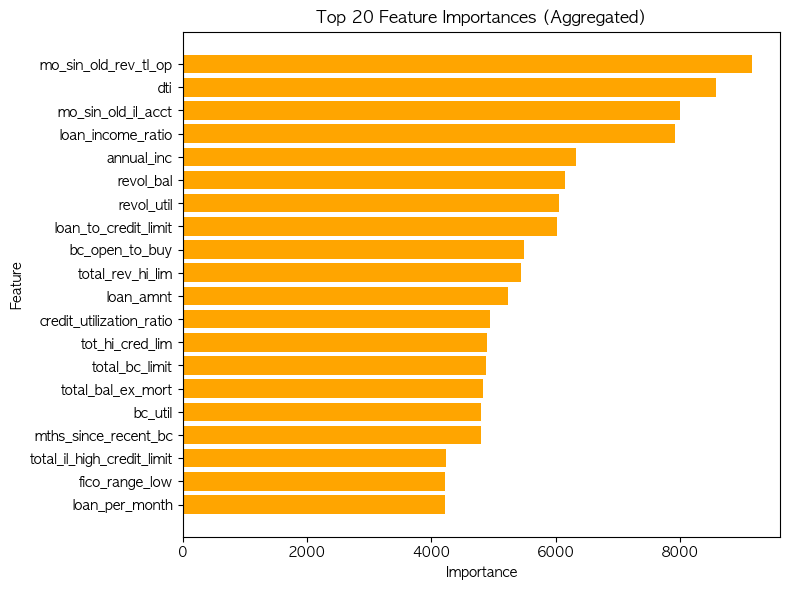

In [40]:
# Top 20 선택
topk = agg_importance.head(20)[::-1]  # 보기 좋게 역순으로 (위에서 큰 값이 위로 오게)

plt.figure(figsize=(8, 6))
plt.barh(topk['OrigFeature'], topk['Importance'], color="orange")
plt.title("Top 20 Feature Importances (Aggregated)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()  